In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import mannwhitneyu

### Datasets in the current analysis
* `dataset` = "omrgcv2" corresponds to Tara Oceans
* `dataset` = "3300003872" corresponds to JGI IMG dataset 3300003872, from the RMR5 sample (black smoker spire, processed with JGI pipeline)
* `dataset` = "3300003873" corresponds to JGI IMG dataset 3300003873, from the RMR-D sample (diffuse hydrothermal vent field, processed with JGI pipeline)
* `dataset` = "3300003177" corresponds to JGI IMG dataset 3300003177, from the RMR5 sample (black smoker spire, unknown processing)
* `dataset` = "3300003178" corresponds to JGI IMG dataset 3300003178, from the RMR-D sample (diffuse hydrothermal vent field, unknown processing)

### Step 1: Select a COG ID and a set of IDR properties
* In the code cell below, insert a value for `COG_ID` and modify the `idr_props` list to define your query and property comparisons
* The full list of valid IDR properties to enter into the `idr_props` list is:
    * `Asphericity`
    * `Radius_of_gyration`
    * `Radius_of_gyration_scaled`
    * `End_to_end_distance`
    * `End_to_end_distance_scaled`
    * `Scaling_exponent`
    * `Prefactor`
    * `Kappa`
    * `Length`
    * `FCR` (fraction charged residues)
    * `NCPR` (net charge per residue)
    * `SHD` (sequence hydropathy decoration)
    * `SCD` (sequence charge decoration)
    * `Molecular_weight`
    * `F_Neg` (fraction negative residues)
    * `F_Pos` (fraction positive residues)
    * `Hydrophobicity`
    * `Fraction_aromatic`
    * `Fraction_aliphatic`
    * `Fraction_polar`
    * `Complexity`

In [2]:
# enter your COG ID here
COG_ID  = "COG0513"

# IDR properties of interest; update to alter the output plots and comparisons made downstream
idr_props = ['Length', 
             'FCR', 
             'NCPR', 
             'SHD', 
             'SCD',
             'F_Neg', 
             'F_Pos', 
             'Hydrophobicity',
             'Fraction_aromatic', 
             'Fraction_aliphatic', 
             'Fraction_polar']

master_props = ['Asphericity','Radius_of_gyration','Radius_of_gyration_scaled','End_to_end_distance',
                'End_to_end_distance_scaled','Scaling_exponent','Prefactor','Kappa','Length','FCR',
                'NCPR','SHD','SCD','Molecular_weight','F_Neg','F_Pos','Hydrophobicity','Fraction_aromatic',
                'Fraction_aliphatic','Fraction_polar','Complexity']

In [3]:
# update this path to point towards your local database
DB_PATH = "../database/minimal_noenv.db"
conn    = sqlite3.connect(DB_PATH)

# helper function 1, runs the query
def run_query(query: str, params: tuple = ()):
    """Run an SQL query and return a pandas DataFrame."""
    with sqlite3.connect(DB_PATH) as conn:
        return pd.read_sql_query(query, conn, params=params)

# helper function 2, builds the query
def query_by_cog_root(cog_root_value: str) -> pd.DataFrame:
    """
    Retrieve rows from architecture, idr_props, and cog_root tables
    joined on 'Gene', filtered by cog_root_ids value.
    """
    query = """
    SELECT 
        a.Gene,
        a.architecture,
        i.*,
        c.cog_root_ids
    FROM architecture AS a
    JOIN idr_props AS i
        ON a.Gene = i.Gene
    JOIN cog_root AS c
        ON a.Gene = c.Gene
    WHERE c.cog_root_ids = ?
    """
    return run_query(query, (cog_root_value,))

def plot_idr_property_boxplots2(df: pd.DataFrame,
                               properties: list[str] = None,
                               group_col: str = "dataset",
                               ncols: int = 4,
                               figsize: tuple = (16, 10)):
    """
    Create subplots of boxplots for IDR properties grouped by dataset,
    and display Mann-Whitney U test p-values between dataset pairs.
    P-values are shown to three decimals, or '<0.001' when smaller.
    If any comparison is significant (p < 0.05), the title is surrounded by { }.
    """
    if properties is None:
        properties = [
            'Length', 'FCR', 'NCPR', 'SHD', 'SCD',
            'Molecular_weight', 'F_Neg', 'F_Pos', 'Hydrophobicity',
            'Fraction_aromatic', 'Fraction_aliphatic', 'Fraction_polar'
        ]

    nplots = len(properties)
    nrows = (nplots + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    axes = axes.flatten()

    datasets = df[group_col].dropna().unique()
    pairs = list(combinations(datasets, 2))

    for i, prop in enumerate(properties):
        ax = axes[i]
        sns.boxplot(data=df, x=group_col, y=prop, ax=ax, fliersize=1)
        ax.set_xlabel("")
        ax.set_ylabel(prop)
        ax.tick_params(axis="x", rotation=45)

        # Mann–Whitney U tests
        pvals = {}
        significant = False
        for a, b in pairs:
            group_a = df.loc[df[group_col] == a, prop].dropna()
            group_b = df.loc[df[group_col] == b, prop].dropna()
            if len(group_a) > 0 and len(group_b) > 0:
                stat, p = mannwhitneyu(group_a, group_b, alternative="two-sided")
                p_formatted = "<0.001" if p < 0.001 else f"{p:.3f}"
                pvals[f"{a} vs {b}"] = p_formatted
                if p < 0.05:
                    significant = True

        # Update title if any significant difference found
        title = f"{{{prop}}}" if significant else prop
        ax.set_title(title)

        # Annotate or print p-values
        if len(pvals) <= 3:
            text = "\n".join([f"{k}: p={v}" for k, v in pvals.items()])
            ax.text(0.05, 0.95, text, transform=ax.transAxes,
                    fontsize=8, va="top", ha="left",
                    bbox=dict(boxstyle="round", facecolor="white", alpha=0.6))
        else:
            print(f"\n{prop}:")
            for k, v in pvals.items():
                print(f"  {k}: p={v}")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    fig.tight_layout()
    plt.show()

In [4]:
# carry out the query and get result as a pandas DataFrame
results = query_by_cog_root(f"{COG_ID}")

# remove duplicate columns from the join
results = results.loc[:, ~results.columns.duplicated()]

# recode IDR property values to numerics
for col in idr_props:
    results[col] = pd.to_numeric(results[col], errors='coerce')

# print number of IDRs retrieved
print(f"{len(results)} unique IDRs retrieved.")

# print summary of the unique IDRs per dataset
print(f"\nNumber of IDRs retrieved per dataset:\n{results['dataset'].value_counts()}\n")

# print the first 10 rows
results.head()

10109 unique IDRs retrieved.

Number of IDRs retrieved per dataset:
dataset
omrgcv2       9872
3300003873     109
3300003177      59
3300003872      44
3300003178      25
Name: count, dtype: int64



,Gene,architecture,dataset,IDR_START,IDR_END,IDR_ID,Asphericity,Radius_of_gyration,Radius_of_gyration_scaled,End_to_end_distance,...,SCD,Molecular_weight,F_Neg,F_Pos,Hydrophobicity,Fraction_aromatic,Fraction_aliphatic,Fraction_polar,Complexity,cog_root_ids
0,OM-RGC.v2.002880019,ORDERED-IDR,omrgcv2,375,451,OM-RGC.v2.002880019_375-451,0.432,25.845,26.818,67.625,...,2.057978,8463.700000000012,0.103896,0.220779,3.428571,0.051948,0.207792,0.311688,0.8694333109179797,COG0513
1,OM-RGC.v2.014909145,ORDERED-IDR-ORDERED-IDR,omrgcv2,61,98,OM-RGC.v2.014909145_61-98,0.473,17.481,17.558,41.473,...,2.029474,4510.599999999999,0.184211,0.394737,1.823684,0.000000,0.078947,0.289474,0.739224365743695,COG0513
2,OM-RGC.v2.014909145,ORDERED-IDR-ORDERED-IDR,omrgcv2,171,227,OM-RGC.v2.014909145_171-227,0.475,25.206,25.244,59.267,...,9.204283,6577.100000000002,0.105263,0.421053,2.128070,0.000000,0.122807,0.228070,0.730403078020779,COG0513
3,OM-RGC.v2.004772224,ORDERED-IDR,omrgcv2,352,377,OM-RGC.v2.004772224_352-377,0.518,15.213,15.213,39.774,...,8.397337,3003.199999999998,0.000000,0.500000,2.411538,0.115385,0.000000,0.346154,0.5599995291895128,COG0513
4,OM-RGC.v2.003752450,ORDERED-IDR,omrgcv2,362,412,OM-RGC.v2.003752450_362-412,0.444,20.574,21.173,52.958,...,2.534196,6156.899999999999,0.078431,0.333333,2.672549,0.117647,0.098039,0.352941,0.7850935463861527,COG0513



Length:
  omrgcv2 vs 3300003872: p=0.001
  omrgcv2 vs 3300003873: p=<0.001
  omrgcv2 vs 3300003178: p=<0.001
  omrgcv2 vs 3300003177: p=<0.001
  3300003872 vs 3300003873: p=0.888
  3300003872 vs 3300003178: p=0.214
  3300003872 vs 3300003177: p=0.792
  3300003873 vs 3300003178: p=0.159
  3300003873 vs 3300003177: p=0.956
  3300003178 vs 3300003177: p=0.198

FCR:
  omrgcv2 vs 3300003872: p=0.073
  omrgcv2 vs 3300003873: p=0.818
  omrgcv2 vs 3300003178: p=<0.001
  omrgcv2 vs 3300003177: p=0.755
  3300003872 vs 3300003873: p=0.134
  3300003872 vs 3300003178: p=<0.001
  3300003872 vs 3300003177: p=0.366
  3300003873 vs 3300003178: p=<0.001
  3300003873 vs 3300003177: p=0.716
  3300003178 vs 3300003177: p=<0.001

NCPR:
  omrgcv2 vs 3300003872: p=0.199
  omrgcv2 vs 3300003873: p=<0.001
  omrgcv2 vs 3300003178: p=0.018
  omrgcv2 vs 3300003177: p=0.025
  3300003872 vs 3300003873: p=0.578
  3300003872 vs 3300003178: p=0.007
  3300003872 vs 3300003177: p=0.805
  3300003873 vs 3300003178: p=<0.0

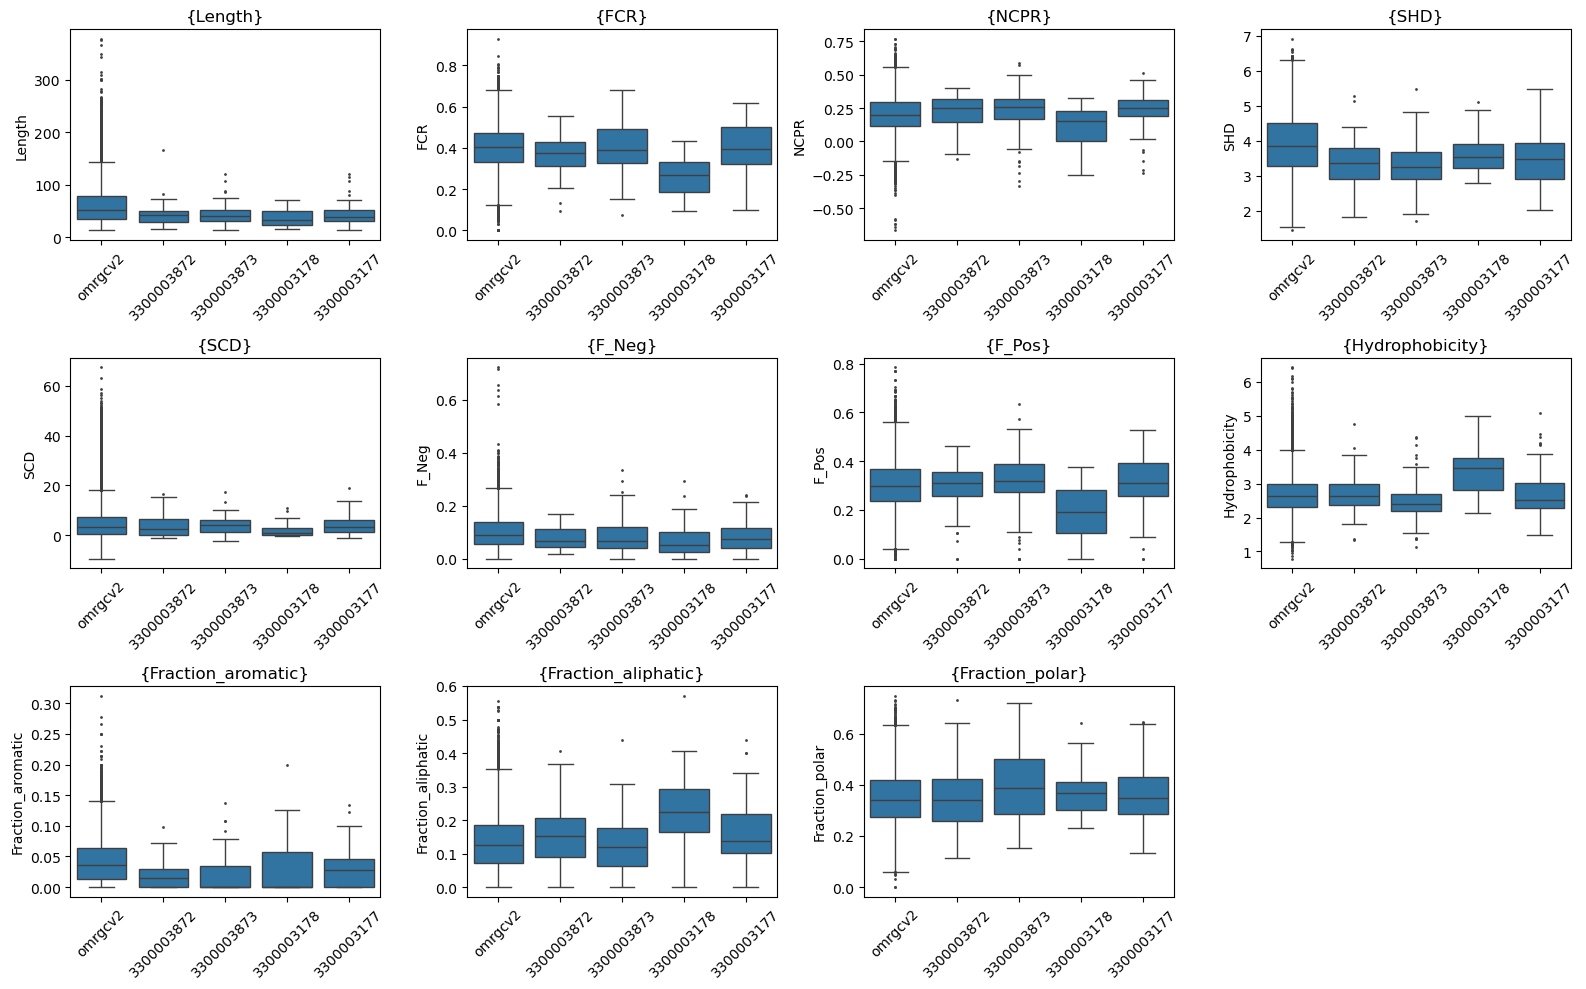

In [5]:
plot_idr_property_boxplots2(results, properties=idr_props)